In [1]:

from imports import *


# Data Prep for the Models
lambdas = np.logspace(-3, 3, 7)
conn = sqlite3.connect('star_reviews.db')
cursor = conn.cursor()
cursor.execute("SELECT * from data Limit 40000")
vectorize = CountVectorizer(stop_words='english')
reviews = []
tables = cursor.fetchall()
column_names = [description[0] for description in cursor.description]
df = pd.DataFrame(tables, columns=column_names)
X = df['processed_text']
Y = df['stars']

from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB, ComplementNB
from sklearn.metrics import accuracy_score
import numpy as np
import sqlite3
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec

In [2]:

# Data Prep for the Models
lambdas = np.logspace(-3, 3, 7)
conn = sqlite3.connect('star_reviews.db')
cursor = conn.cursor()
cursor.execute("SELECT * from data Limit 40000")
vectorize = CountVectorizer(stop_words='english')
reviews = []
tables = cursor.fetchall()
column_names = [description[0] for description in cursor.description]
df = pd.DataFrame(tables, columns=column_names)
X = df['processed_text']
Y = df['stars']

# Word2Vec Embedding
def embed_reviews(X):
    # Tokenize and embed using Word2Vec
    tokenized_X = [text.split() for text in X]
    model = Word2Vec(sentences=tokenized_X, vector_size=100, window=5, min_count=1, workers=4)
    
    def get_embedding(text):
        word_vectors = [model.wv[word] for word in text.split() if word in model.wv]
        return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.vector_size)
    
    embedded_X = np.array([get_embedding(text) for text in X])
    
    embedded_X = np.maximum(embedded_X, 0)
    
    return embedded_X

# Vectorize the data using CountVectorizer
VectorizedX = vectorize.fit_transform(X)

# Get the Word2Vec embeddings for the reviews
X_embedded = embed_reviews(X)

# Split the data into training and test sets
trainX_vectorized, testX_vectorized, trainY, testY = train_test_split(VectorizedX, Y, test_size=0.2)
trainX_embedded, testX_embedded = train_test_split(X_embedded, test_size=0.2)

# Initialize dictionaries to store results
vectorized_results = {}
embedded_results = {}

# List of all Naive Bayes models to iterate over
naive_bayes_models = [
    ("MultinomialNB", MultinomialNB()),
    ("BernoulliNB", BernoulliNB()),
    ("ComplementNB", ComplementNB()),
    ("GaussianNB", GaussianNB())
]

# Function to print progress
def print_progress(model_name):
    print(f"Running {model_name}...")

# Sparse Naive Bayes calculations (vectorized data)
for model_name, model in naive_bayes_models:
    print_progress(model_name)
    try:
        # Convert to dense data for GaussianNB and CategoricalNB
        if model_name in ["GaussianNB", "CategoricalNB"]:
            trainX_vectorized_dense = trainX_vectorized.toarray()
            testX_vectorized_dense = testX_vectorized.toarray()
        else:
            trainX_vectorized_dense = trainX_vectorized
            testX_vectorized_dense = testX_vectorized
        
        # For vectorized data
        model.fit(trainX_vectorized_dense, trainY)
        train_prediction = model.predict(trainX_vectorized_dense)
        test_prediction = model.predict(testX_vectorized_dense)
        
        train_score = accuracy_score(trainY, train_prediction)
        test_score = accuracy_score(testY, test_prediction)
        
        if model_name not in vectorized_results:
            vectorized_results[model_name] = {}
        
        vectorized_results[model_name]["train_score"] = train_score * 100
        vectorized_results[model_name]["test_score"] = test_score * 100
        print(f"{model_name} (Vectorized) - Train Accuracy: {train_score * 100:.2f}% | Test Accuracy: {test_score * 100:.2f}%")
        
    except Exception as e:
        print(f"{model_name} failed on vectorized data: {str(e)}")

# Sparse Naive Bayes calculations (Word2Vec embedded data)
for model_name, model in naive_bayes_models:
    print_progress(model_name)
    try:
        # For Word2Vec embedded data
        model.fit(trainX_embedded, trainY)
        train_prediction = model.predict(trainX_embedded)
        test_prediction = model.predict(testX_embedded)
        
        train_score = accuracy_score(trainY, train_prediction)
        test_score = accuracy_score(testY, test_prediction)
        
        if model_name not in embedded_results:
            embedded_results[model_name] = {}
        
        embedded_results[model_name]["train_score"] = train_score * 100
        embedded_results[model_name]["test_score"] = test_score * 100
        print(f"{model_name} (Word2Vec) - Train Accuracy: {train_score * 100:.2f}% | Test Accuracy: {test_score * 100:.2f}%")
        
    except Exception as e:
        print(f"{model_name} failed on embedded data: {str(e)}")

print("\nVectorized Results:", vectorized_results)
print("\nEmbedded Results:", embedded_results)


Running MultinomialNB...
MultinomialNB (Vectorized) - Train Accuracy: 75.62% | Test Accuracy: 63.56%
Running BernoulliNB...
BernoulliNB (Vectorized) - Train Accuracy: 63.46% | Test Accuracy: 55.38%
Running ComplementNB...
ComplementNB (Vectorized) - Train Accuracy: 77.04% | Test Accuracy: 64.05%
Running GaussianNB...
GaussianNB (Vectorized) - Train Accuracy: 60.45% | Test Accuracy: 38.44%
Running MultinomialNB...
MultinomialNB (Word2Vec) - Train Accuracy: 44.44% | Test Accuracy: 44.41%
Running BernoulliNB...
BernoulliNB (Word2Vec) - Train Accuracy: 44.44% | Test Accuracy: 44.42%
Running ComplementNB...
ComplementNB (Word2Vec) - Train Accuracy: 25.26% | Test Accuracy: 24.01%
Running GaussianNB...
GaussianNB (Word2Vec) - Train Accuracy: 12.33% | Test Accuracy: 12.03%

Vectorized Results: {'MultinomialNB': {'train_score': 75.615625, 'test_score': 63.5625}, 'BernoulliNB': {'train_score': 63.456250000000004, 'test_score': 55.375}, 'ComplementNB': {'train_score': 77.04062499999999, 'test_sco

In [5]:
vectorized_results

{'MultinomialNB': {'train_score': 75.615625, 'test_score': 63.5625},
 'BernoulliNB': {'train_score': 63.456250000000004, 'test_score': 55.375},
 'ComplementNB': {'train_score': 77.04062499999999, 'test_score': 64.05},
 'GaussianNB': {'train_score': 60.453125, 'test_score': 38.4375}}

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

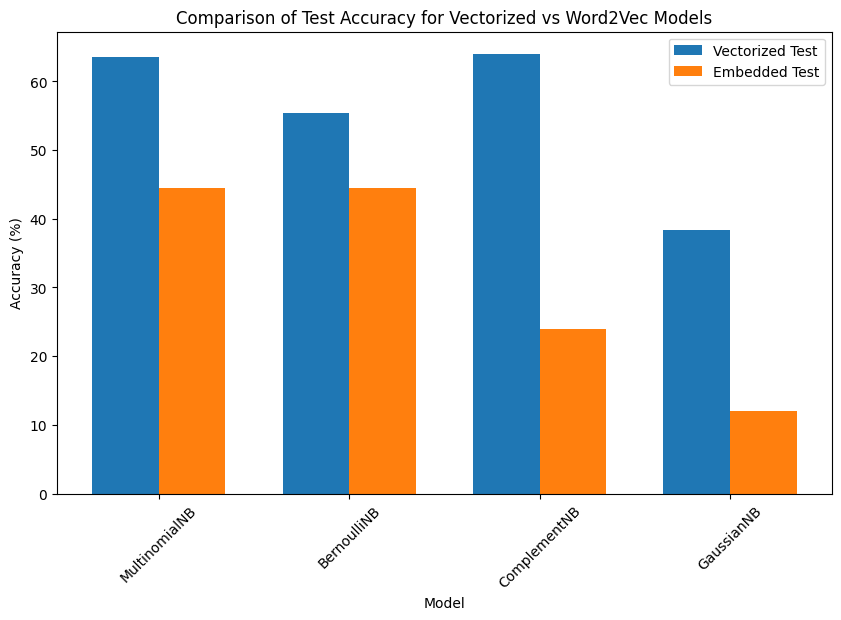

In [6]:

model_names = list(vectorized_results.keys())

# Extract train and test scores for both vectorized and embedded results
vectorized_train_scores = [vectorized_results[model]["train_score"] for model in model_names]
vectorized_test_scores = [vectorized_results[model]["test_score"] for model in model_names]

embedded_train_scores = [embedded_results[model]["train_score"] for model in model_names]
embedded_test_scores = [embedded_results[model]["test_score"] for model in model_names]

x = np.arange(len(model_names))
width = 0.35


fig, ax = plt.subplots(figsize=(10, 6))

bar1 = ax.bar(x - width/2, vectorized_test_scores, width, label='Vectorized Test')
bar2 = ax.bar(x + width/2, embedded_test_scores, width, label='Embedded Test')

# Labeling the graph
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Comparison of Test Accuracy for Vectorized vs Word2Vec Models')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

# Display the bar graph
plt.xticks(rotation=45)
plt.tight_layout


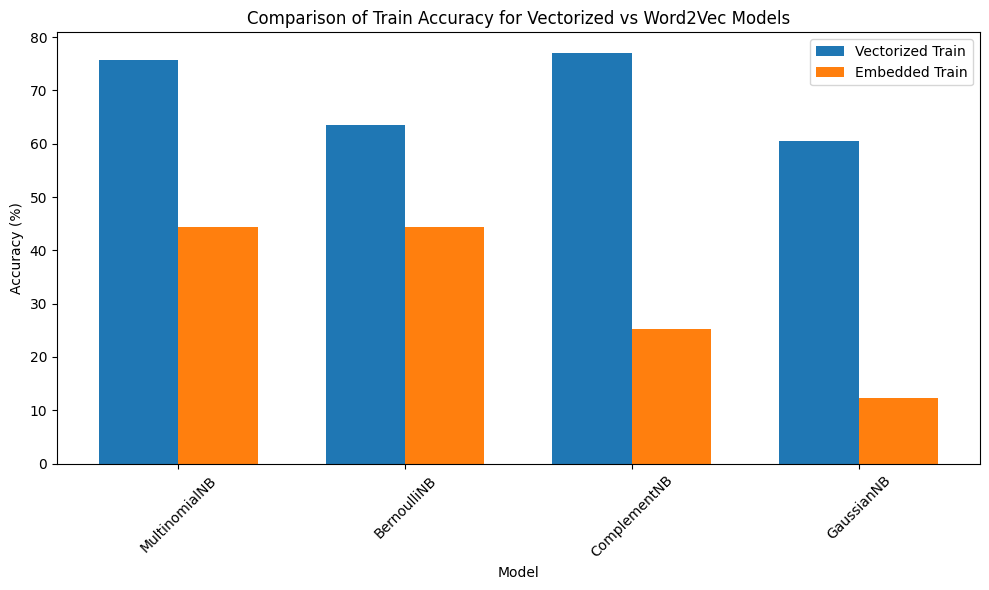

In [7]:
# Extract results
model_names = list(vectorized_results.keys())


vectorized_train_scores = [vectorized_results[model]["train_score"] for model in model_names]
vectorized_test_scores = [vectorized_results[model]["test_score"] for model in model_names]

embedded_train_scores = [embedded_results[model]["train_score"] for model in model_names]
embedded_test_scores = [embedded_results[model]["test_score"] for model in model_names]


x = np.arange(len(model_names))
width = 0.35

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for vectorized and embedded results
bar1 = ax.bar(x - width/2, vectorized_train_scores, width, label='Vectorized Train')
bar2 = ax.bar(x + width/2, embedded_train_scores, width, label='Embedded Train')

# Labeling the graph
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Comparison of Train Accuracy for Vectorized vs Word2Vec Models')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

# Display the bar graph
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
